In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Understanding


In [16]:
train_a = pd.read_csv('../Dataset/Data_A/data_train_A.csv')
dev_a = pd.read_csv('../Dataset/Data_A/data_dev_A.csv')
test_a = pd.read_csv('../Dataset/Data_A/data_test_A.csv')
train_b = pd.read_csv('../Dataset/Data_B/data_train_B.csv')
dev_b = pd.read_csv('../Dataset/Data_B/data_dev_B.csv')
test_b = pd.read_csv('../Dataset/Data_B/data_test_B.csv')

In [17]:
print("Data Train A:")
print(train_a.head())
print("\nKolom:", train_a.columns.tolist())

Data Train A:
  RES_ID                                           RESPONSE  LABEL
0   TRA1  intetraksi/beradaptasi terhadap lingkungan yan...      1
1   TRA2         seperti jatuhnya meteor tsunami gempa bumi      0
2   TRA3      hanya tuhan yang tahu tantangan nya itu apaan      0
3   TRA4                      mereka akan sulit beradaptasi      1
4   TRA5             Tempat tinggal, ekonomi, dan pekerjaan      1

Kolom: ['RES_ID', 'RESPONSE', 'LABEL']


In [18]:
print("Data Train B:")
print(train_b.head())
print("\nKolom:", train_b.columns.tolist())

Data Train B:
  RES_ID                                           RESPONSE  LABEL
0   TRB1  Karena orang berpikir bahwa jika disumbangkan ...      1
1   TRB2  Pakaian awet adalah alternatif terhadap Fast F...      0
2   TRB3                  karna orang lebih suka menyumbang      1
3   TRB4               karana harga nya terjangkau dan pas.      0
4   TRB5                            kerena harganya mahal .      0

Kolom: ['RES_ID', 'RESPONSE', 'LABEL']


In [19]:
stimulus_a = ["Pemanasan global terjadi karena peningkatan produksi karbon dioksida yang dihasilkan oleh pembakaran fosil dan konsumsi bahan bakar yang tinggi.",
"Salah satu akibat adalah mencairnya es abadi di kutub utara dan selatan yang menimbulkan naiknya ketinggian air laut.",
"kenaikan air laut akan terjadi terus menerus meskipun dalam hitungan centimeter akan mengakibatkan perubahan yang signifikan.",
"Film “Waterworld”, adalah film fiksi ilmiah yang menunjukkan akibat adanya pemanasan global yang sangat besar sehingga menyebabkan bumi menjadi tertutup oleh lautan.",
"Negara-negara dan daratan yang dulunya kering menjadi tengelamn karena terjadi kenaikan permukaan air laut.",
"Penduduk yang dulunya bisa berkehidupan bebas menjadi terpaksa mengungsi ke daratan yang lebih tinggi atau tinggal diatas air.",
"Apa yang akan menjadi tantangan bagi suatu penduduk ketika terjadi situasi daratan tidak dapat ditinggali kembali karena tengelam oleh naiknya air laut."]

stimulus_b = ["Sebuah toko baju berkonsep self-service menawarkan promosi dua buah baju bertema tahun baru seharga Rp50.000,00. sebelum baju bertema tahun baru dibagikan kepada pembeli, sebuah layar akan menampilkan tampilan gambar yang menampilkan kondisi kerja di dalam sebuah pabrik konveksi/pembuatan baju. ",
"Kemudian pembeli diberi program pilihan untuk menyelesaikan pembeliannya atau menyumpangkan Rp50.000,00 untuk dijadikan donasi pembagian baju musim dingin di suatu daerah yang membutuhkan.",
"Delapan dari sepuluh pembeli memilih untuk memberikan donasi.",
"Menurut anda mengapa banyak dari pembeli yang memilih berdonasi?"]

In [20]:
print(train_a.info())
print(train_a.describe(include='all'))  
print(train_b.info())
print(train_b.describe(include='all'))  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   RES_ID    268 non-null    object
 1   RESPONSE  268 non-null    object
 2   LABEL     268 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 6.4+ KB
None
       RES_ID                                           RESPONSE       LABEL
count     268                                                268  268.000000
unique    268                                                265         NaN
top      TRA1  Pengungsi iklim adalah orang-orang yang terpak...         NaN
freq        1                                                  3         NaN
mean      NaN                                                NaN    0.712687
std       NaN                                                NaN    0.453356
min       NaN                                                NaN    0.000000
25%       NaN                      

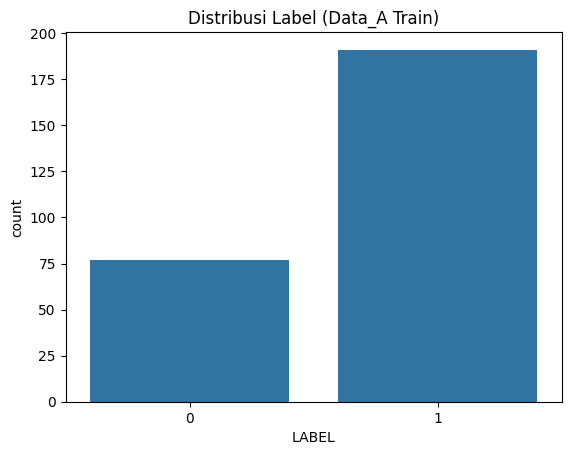

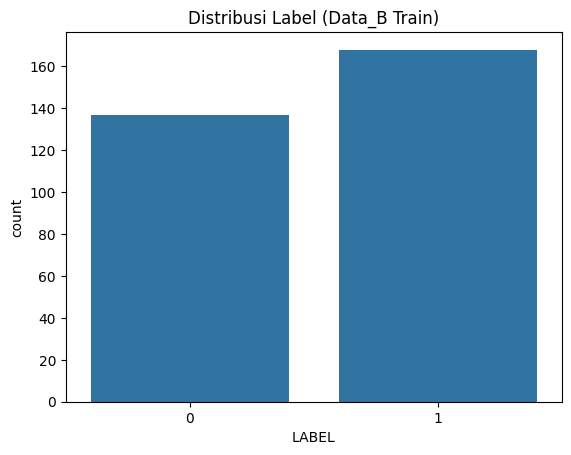

In [23]:
sns.countplot(x='LABEL', data=train_a)
plt.title('Distribusi Label (Data_A Train)')
plt.show()

sns.countplot(x='LABEL', data=train_b)
plt.title('Distribusi Label (Data_B Train)')
plt.show()

# Opsi

1. Bert prepocessing + Model
2. Bert Prepocessing, Model Neural
3. Bert ...
